<a href="https://colab.research.google.com/github/wesley34/comp3414_course_material/blob/master/ch_9_basic_reinforcement_learning/deep_reinforcement_withCartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 3.5MB/s 


In [ ]:
import gym
from collections import namedtuple
import numpy as np
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [ ]:
class Net(nn.Module):
  def __init__(self,observation_size,hidden_size,n_actions):
    super(Net,self).__init__()
    self.net = nn.Sequential(
        nn.Linear(observation_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,n_actions)
    )
  def forward(self,x):
    return self.net(x)


In [ ]:
Episode = namedtuple("Episode",field_names=["reward","steps"])
EpisodeStep = namedtuple("EpisodeStep",field_names=["observation","action"])

In [ ]:
def iterate_batches(env,net,batch_size):
  batch = []
  episode_reward = 0.0
  episode_steps = []
  obs = env.reset()
  sm = nn.Softmax(dim=1)

  while True:
    obs_v = torch.FloatTensor([obs])
    act_probs_v = sm(net(obs_v))
    act_probs = act_probs_v.data.numpy()[0]
    action = np.random.choice(len(act_probs),p=act_probs)
    next_obs, reward, is_done, _ = env.step(action)
    episode_reward += reward
    episode_steps.append(EpisodeStep(observation=obs,action=action))

    if is_done:
      batch.append(Episode(reward=episode_reward,steps=episode_steps))
      episode_reward = 0
      episode_steps = []
      next_obs = env.reset()
      if (len(batch) == batch_size):
        yield batch
        batch = []
    obs = next_obs


In [ ]:
def filter_batch(batch,precentile):
  rewards = list(map(lambda s:s.reward,batch))
  reward_bound = np.percentile(rewards,PERCENTILE)
  reward_mean = float(np.mean(rewards))

  train_observation = []
  train_action = []
  for example in batch:
    if example.reward < reward_bound:
      continue
    train_observation.extend(map(lambda step:step.observation,example.steps))
    train_action.extend(map(lambda step:step.action,example.steps))
  train_observation_vector = torch.FloatTensor(train_observation)
  train_action_vector = torch.FloatTensor(train_action)
  return train_observation_vector,train_action_vector,reward_bound,reward_mean


In [ ]:
env = gym.make("CartPole-v0")
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

In [ ]:
net = Net(obs_size,HIDDEN_SIZE,n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(),lr=0.01)
writer = SummaryWriter(comment="-cartpole")

In [ ]:
for iter_no,batch in enumerate(iterate_batches(env,net,BATCH_SIZE)):
  observation_vector, action_vector, reward_bound, reward_mean = filter_batch(batch, PERCENTILE)
  optimizer.zero_grad()
  action_score_vector = net(observation_vector)
  action_vector = action_vector.long()
  loss_vector = objective(action_score_vector,action_vector)
  loss_vector.backward()
  optimizer.step()
  print("%d, loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" %(iter_no,loss_vector.item(),reward_mean,reward_bound))
  writer.add_scalar("loss",loss_vector.item(),iter_no)
  writer.add_scalar("reward_bound",reward_bound,iter_no)
  writer.add_scalar("reward_mean",reward_mean,iter_no)
  if reward_mean > 199:
    print("Solved")
    break
  writer.close()

0, loss=0.692, reward_mean=26.7, reward_bound=31.5
1, loss=0.703, reward_mean=19.1, reward_bound=18.0
2, loss=0.678, reward_mean=26.9, reward_bound=32.5
3, loss=0.676, reward_mean=30.6, reward_bound=24.5
4, loss=0.667, reward_mean=33.2, reward_bound=34.0
5, loss=0.654, reward_mean=31.4, reward_bound=40.0
6, loss=0.652, reward_mean=44.3, reward_bound=43.5
7, loss=0.648, reward_mean=49.3, reward_bound=57.5
8, loss=0.623, reward_mean=48.9, reward_bound=58.0
9, loss=0.620, reward_mean=51.0, reward_bound=49.5
10, loss=0.617, reward_mean=73.2, reward_bound=73.5
11, loss=0.623, reward_mean=65.6, reward_bound=82.0
12, loss=0.620, reward_mean=58.0, reward_bound=65.0
13, loss=0.596, reward_mean=69.6, reward_bound=84.0
14, loss=0.602, reward_mean=79.2, reward_bound=102.0
15, loss=0.593, reward_mean=66.0, reward_bound=79.0
16, loss=0.586, reward_mean=71.6, reward_bound=78.5
17, loss=0.584, reward_mean=72.9, reward_bound=79.5
18, loss=0.565, reward_mean=68.6, reward_bound=72.5
19, loss=0.581, rewar

In [ ]:
action_vector.shape

torch.Size([3000])

In [ ]:
action_score_vector.shape

torch.Size([3000, 2])

In [ ]:
n_actions

2

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 993 kB in 1s (1,101 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144579 files and director

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [ ]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

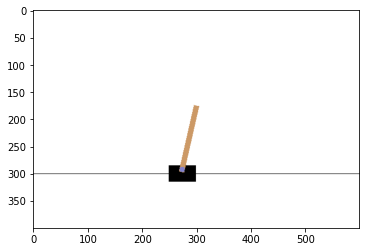

In [ ]:
## config 
env = gym.make("CartPole-v0")
sm = nn.Softmax(dim=1)
observation = env.reset()
observation = torch.FloatTensor([observation])

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(2500):

  action = env.action_space.sample()
  network_output = net(observation)
  pred_step_probability = sm(network_output).data.numpy()[0]
  pred_step = np.random.choice(len(pred_step_probability),p=pred_step_probability)
  obs, reward, done, info = env.step(pred_step)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    print("END")
    break

ipythondisplay.clear_output(wait=True)
env.close()